In [1]:
import os, sys, json
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("..")
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# read from json
data = None
data_path = "../../../output/prioplus-eurosys25/experiments/"
experiment_name = "fig3b"
with open(data_path + experiment_name + ".json", "r") as f:
    data = json.load(f)

In [ ]:
# In this experiment, we have four flows and a bottleneck link
# Draw the send rate of each flow in subfigure1
# And draw the queue length of the bottleneck link in subfigure2

# Calculate the send rate from data{flowStatistics:[0:4]:sentPkt:[timeNs,sizeByte]}
# The send rate is calculated by the number Bytes sent in each time interval
send_rate_interval_ns = 10e4  # 10us
send_rate = []
# calculate the total send rate of first 300 flows and the last flows

prio_num = 2
flow_num = 2
pkt_idxs = [0 for _ in range(prio_num*flow_num)]
for p in range(prio_num):
    send_rate.append([])
    wnd_start = data["flowStatistics"][0]["sentPkt"][0]["timeNs"]
    # the first point
    send_rate[p].append({"timeNs": wnd_start, "sendRateGbps": 0})
    wnd_data = 0
    
    while True:
        wnd_data = 0
        next_wnd_start = wnd_start + send_rate_interval_ns
        for i in range(flow_num):
            pkt_idx = 0
            flow_idx = p * flow_num + i
            for pkt_idx in range(pkt_idxs[flow_idx], len(data["flowStatistics"][flow_idx]["sentPkt"])):
                sentPkt = data["flowStatistics"][flow_idx]["sentPkt"][pkt_idx]
                if sentPkt["timeNs"] - wnd_start > send_rate_interval_ns:
                    # Gbps = bpns
                    # pkt_idxs[flow_idx] = pkt_idx - 1
                    break
                wnd_data += sentPkt["sizeByte"]
            pkt_idxs[flow_idx] = pkt_idx
        send_rate[p].append({"timeNs": wnd_start + send_rate_interval_ns/2,
                            "sendRateGbps": wnd_data * 8 / send_rate_interval_ns})
        wnd_start = next_wnd_start

        should_break = True
        for i in range(flow_num):
            if pkt_idxs[flow_idx] < len(data["flowStatistics"][flow_idx]["sentPkt"]) - 1:
                should_break = False
                break
        if should_break:
            break
    # the last point
    send_rate[p].append({"timeNs": wnd_start + send_rate_interval_ns/2,
                        "sendRateGbps": 0})

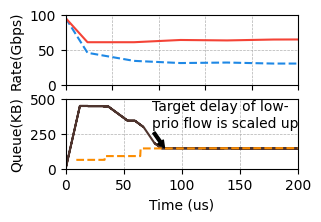

In [5]:
# draw the send rate in a new figure
fig = plt.figure(figsize=(3, 2))
ax1 = fig.add_subplot(211)
# ax.set_xlabel("Time (us)")
ax1.set_ylabel("Rate(Gbps)")

legend_lines = []

color_rate = ["#F44336", "#1E88E5"]
idx = {
    0: 1,
    1: 0
}
color_queue = ["#4E342E", "#FB8C00"]
line_style = ["-","--"]

time_shift = 100e3+3
for i in [0, 1]:
    line = ax1.plot([0]+[s["timeNs"]/1e3 - time_shift for s in send_rate[i]][1:], [95.2]+[s["sendRateGbps"]
                                                                                          for s in send_rate[i]][1:], label="flow"+str(i), color=color_rate[idx[i]], linestyle=line_style[idx[i]])
    legend_lines.append(line[0])
ax1.grid(True, linestyle='--', linewidth=0.5, which='both', axis='both')
ax1.set_xlim(0, 500)
ax1.set_ylim(0, 100)
# hide x-axis label and ticks
ax1.xaxis.set_tick_params(labelbottom=False)

ax2 = fig.add_subplot(212)
ax2.set_xlabel("Time (us)")
ax2.set_ylabel("Queue(KB)")

switch_idx = 0
port_idx = 7
queue_idx = 0
# time_shift = 100e3 + 10
line = ax2.plot([q["timeNs"]/1e3 - time_shift for q in data["switchStatistics"][switch_idx]["portStats"][port_idx]["queueStats"][queue_idx]["qLength"]],
                [q["lengthBytes"] / 1024 for q in data["switchStatistics"][switch_idx]["portStats"][port_idx]["queueStats"][queue_idx]["qLength"]], label="Queue Length", color=color_queue[0], linestyle=line_style[0])
legend_lines.append(line[0])
def target_to_queue(tar):
    return tar * 1e-9 * 100e9 / 8 - 150e3
line = ax2.plot([t["timeNs"]/1e3 - time_shift for t in data["flowStatistics"][0]["ccStats"]["targetDelay"]],
                [target_to_queue(t["targetDelayNs"])/1024 for t in data["flowStatistics"][0]["ccStats"]["targetDelay"]], label="flow0 target delay", color=color_queue[1], linestyle=line_style[1])
# line = ax2.plot([t["timeNs"]/1e3 - time_shift for t in data["flowStatistics"][2]["ccStats"]["targetDelay"]],
#                 [target_to_queue(t["targetDelayNs"])/1024 for t in data["flowStatistics"][2]["ccStats"]["targetDelay"]], label="flow0 target delay", color=color_queue[1], linestyle=line_style[1])
legend_lines.append(line[0])

ax2.annotate('Target delay of low-\nprio flow is scaled up', xy=(85, 150), xytext=(-9, 15),
            xycoords='data', textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0, width=2, headlength=5, headwidth=5),
            )

# ax.axhline(y=400, color='r', linestyle='--', label="ECN Threshold")
ax2.grid(True, linestyle='--', linewidth=0.5, which='both', axis='both')
ax2.set_xlim(0, 200)
ax2.set_ylim(0, 500)

plt.savefig("../figures/" + "fig3b" +
            ".pdf", bbox_inches='tight', dpi=600, format='pdf')

In [6]:
figlegend = plt.figure(figsize=(8,1))
# 减少legend的白边
plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.2)
# interchange the order of the labels in pair

label_names = ["High-prio flow", "Low-prio flow", "Queue Length", "Target Delay"]
legend_lines = [legend_lines[1], legend_lines[0], legend_lines[2], legend_lines[3]]

figlegend.legend(legend_lines, label_names, loc='center', ncol=len(label_names), frameon=False)
figlegend.savefig("../figures/fig3" + "-legend.pdf", bbox_inches="tight", pad_inches=0.0, dpi=600, format="pdf")

<Figure size 800x100 with 0 Axes>